# disordered cluster, global force only

- w=1
- r=[0,1,10]
- tau_info=[tau_social, tau_social/10, 10 tau_social]

In [1]:
import simulation

#tauinfo=0.039
for r in [1,0,.1]:
    simulation.run(tau=0.039,noise=0.158,informed_ratio=r,simtime=6000,w_informed=1,tau_info=0.039)

total steps: 1538461


for loop: 100%|██████████| 1538461/1538461 [2:53:36<00:00, 147.70it/s]  


finished execution with 10416.05845 s
total steps: 1538461


for loop: 100%|██████████| 1538461/1538461 [2:34:29<00:00, 165.98it/s]  


finished execution with 9269.13446 s
total steps: 1538461


for loop: 100%|██████████| 1538461/1538461 [2:44:27<00:00, 155.92it/s]  

finished execution with 9867.09223 s


steps 1000 N 2500


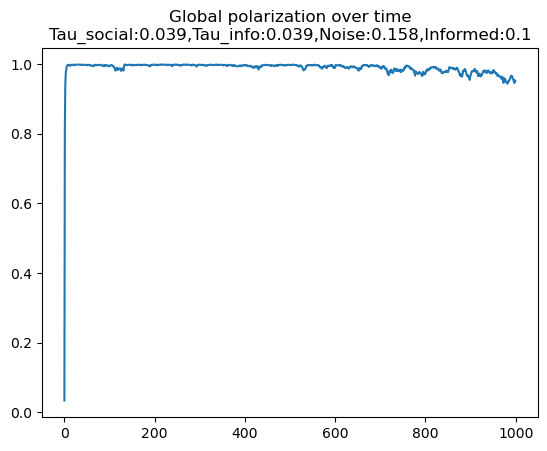

animation tau0d039_noise0d158_r0d1_simtime6000_k3_N2500_w1_tauinfo_0d039_iter1


TypeError: ani() missing 1 required positional argument: 'params'

In [10]:
lognames = ['tau0d039_noise0d158_r0d1_simtime6000_k3_N2500_w1_tauinfo_0d039_iter1','tau0d039_noise0d158_r0_simtime6000_k3_N2500_w1_tauinfo_0d039_iter1','tau0d039_noise0d158_r1_simtime6000_k3_N2500_w1_tauinfo_0d039_iter1']
for logname in lognames:
    analyze_pipe(logname)

# before 4/14

In [6]:
import numpy as np
#from knowing import periodic_phi,prep_arrs,image,periodicKD
import matplotlib.pyplot as plt, seaborn as sns
import networkx as nx
from matplotlib.animation import FuncAnimation
import matplotlib.animation as animation
import pandas as pd
from matplotlib.colors import Normalize
import matplotlib.cm as cm

def load_data_new(logname):
    #parameters   
    paramsdf = pd.read_csv(f'{logname}/metadata.csv').loc[0] #get rid of index
    params = {'noise':paramsdf['noise'],'tau':paramsdf['tau'],'tau_info':paramsdf['tau_info'],'informed_ratio':paramsdf['informed_ratio'],'rightdir':paramsdf['rightdir'],\
        'size': paramsdf['size'], 'k': paramsdf['k'], 'N': paramsdf['N'], 'speed':paramsdf['speed'],'simtime':paramsdf['simtime'],'noise_informed':paramsdf['noise_informed'],'w_informed':paramsdf['w_informed'],'count':paramsdf['count'],'firststep':paramsdf['firststep'],'who_correct':paramsdf['who_correct']}
    #params['who_correct'][1]

    #data
    output = pd.read_csv(f'{logname}/data.csv',header=None) #don't read first row as header
    output.columns = ['steps','posx','posy','phi']
    steps = output['steps'].unique()
    print("steps", len(steps),"N",params['N'])
    output['id']= list(range(params['N']))*len(steps)

    #pivot table style
    df = output.pivot_table(index='steps', columns='id')

    return output, params

In [30]:
#stats

def calculate_polarization(phis):
    x_sum = np.sum(np.cos(phis))
    y_sum = np.sum(np.sin(phis))
    magnitude = np.sqrt(x_sum**2 + y_sum**2)/len(phis)
    return magnitude

#global polarization metric

def calc_polarity_step(output,params,step):
    phis = output[output['steps']==step]['phi']
    mean = calculate_polarization(phis)
    return mean

def calc_polarity_stat(output,params):
    #global polarization timeseries for sim10
    means = [] 
    for s in output['steps'].unique():
        mean_s = calc_polarity_step(output,params,step=s)
        means.append(mean_s)
    
    fig,ax=plt.subplots()
    ax.plot(means)
    ax.set_title(f"Global polarization over time\nTau_social:{params['tau']},Tau_info:{params['tau_info']},Noise:{params['noise']},Informed:{params['informed_ratio']}")
    plt.savefig(f"{params['tau']}_{params['noise']}_{params['informed_ratio']}_polarization.png")
    plt.show()
    ax.clear()

    #if params['simtime']>=10000: #no more
    index = int(len(output['steps'].unique())//5)
    start = int(output['steps'].unique()[index])
    print("global polarization mean:",np.average(means[int(len(means)/4):])) #every 10th TO JUSTIFY

#animation 
import numpy as np
from sklearn.neighbors import KDTree
from numba import njit
import time
import os
from tqdm import tqdm
#from knowing import periodic_phi,prep_arrs,image,periodicKD
import matplotlib.pyplot as plt, seaborn as sns
#import networkx as nx
from matplotlib.animation import FuncAnimation
import matplotlib.animation as animation
import pandas as pd
from matplotlib.colors import Normalize
import matplotlib.colors as colors
import matplotlib.cm as cm

def ani(logname,output,params):
    norm = colors.Normalize(vmin=-np.pi,vmax=np.pi)
    mapper = cm.ScalarMappable(norm=norm, cmap='hsv')
    fig,ax=plt.subplots(figsize=(7,7))
    ax.set_xlim(0, params['size']) 
    ax.set_ylim(0, params['size']) 
    ax.set_xticks([])
    ax.set_yticks([])

    fr = list(output['steps'].unique())[::10]

    def update(frame):
        ax.clear()
        ax.set_xlim(0, params['size'])  
        ax.set_ylim(0, params['size'])  
        ax.set_xticks([])
        ax.set_yticks([])
        step_data = output[output['steps'] == frame]
        for idx, row in step_data.iterrows():
            position_x = row['posx']
            position_y = row['posy']
            phi_angle = row['phi']
            color = mapper.to_rgba(phi_angle) 
            ax.arrow(position_x, position_y, 
                     0.05 * np.cos(phi_angle), 0.05 * np.sin(phi_angle), #dx,dy
                     head_width=0.04, head_length=0.04, 
                     color=color)
        ax.set_xlabel(f"Simulation time: {np.round(frame*params['tau']/10,3)}") #count in simulation time 
        ax.set_title(f"{logname}\nTau:{params['tau']},Noise:{params['noise']},Informed:{params['informed_ratio']}")

    ani = FuncAnimation(fig, update, frames=fr, blit=False, repeat=False)
    ani.save(f'{logname}.gif', writer='pillow')

In [12]:
import networkx as nx
from simulation import prep_arrs, image, periodicKD

def recalc_nbs(output,params,step):
    """recalculate interaction from positions"""
    posx = output[output['steps']==step]['posx']
    posy = output[output['steps']==step]['posy']
    pos = np.array([posx,posy]).transpose()
    x,y,x2,x3,y1,y3= prep_arrs(pos)
    xall,yall=image(x,y,x2,x3,y1,y3,params['size'])
    im=np.transpose(np.array([xall,yall]))
    nbs = periodicKD(k=params['k'],pos=pos,image=im)
    return nbs,pos

def build_graph(nbs,N):
    """make graph from interactions"""
    #TODO mark the informed individuals.
    agentlist = np.arange(N)
    graph=nx.DiGraph()
    graph.add_nodes_from(agentlist)
    for agent in range(N):
        for v in nbs[agent]:
            graph.add_edge(agent,v)
            #nbs[v].remove(agent) #remove duplicate links if undirected graph
    return graph

def build_clusters(graph):
    """make clusters based on weakly connected component subgraphs"""
    #TODO constraint: each agent can only belong to at most one subgraph. 
    digraphs = [graph.subgraph(c).copy() for c in nx.weakly_connected_components(graph)]
    return digraphs

def calc_cluster_step(digraphs, output, params, step):
    means = [] 
    sizes = []
    for digraph in digraphs:
        members = list(digraph.nodes)
        
        phis = output[output['id'].isin(members)][output['steps']==step]['phi']
        mean = calculate_polarization(phis)
        means.append(mean)
        
        size = digraph.number_of_nodes()
        sizes.append(size)
        
    meansavg = np.mean(means)
    sizesavg = np.mean(sizes)

    return meansavg, sizesavg

import warnings
warnings.filterwarnings("ignore")

def calc_cluster_timeseries(output, params):
    mlist = []
    slist = []
    stepping = list(output['steps'].unique())
    for s in stepping[300::10]:
        nbs,pos = recalc_nbs(output=output,params=params,step=s) 
        graph = build_graph(nbs,params['N'])
        digraphs= build_clusters(graph)
        meansavg, sizesavg = calc_cluster_step(digraphs, output, params, s)
        mlist.append(meansavg)
        slist.append(sizesavg)
    return mlist, slist

def calc_cluster_stat(output, params):
    nowm,nows = calc_cluster_timeseries(output, params)
    fig,ax=plt.subplots()
    ax.clear()
    ax.plot(nowm)
    plt.xlabel("time")
    plt.ylabel("average cluster polarization")
    plt.title(f"average cluster polarization over time\nTau:{params['tau']},Noise:{params['noise']},Informed:{params['informed_ratio']}")
    plt.savefig(f"{params['tau']}_{params['noise']}_{params['informed_ratio']}_cluster_polarization.png")
    plt.show()

    ax.clear()
    plt.plot(nows)
    plt.xlabel("time")
    plt.ylabel("average cluster size")
    plt.title(f"average cluster size over time\nTau:{params['tau']},Noise:{params['noise']},Informed:{params['informed_ratio']}")
    plt.savefig(f"{params['tau']}_{params['noise']}_{params['informed_ratio']}_cluster_size.png")
    plt.show()
    
    return np.mean(nowm), np.mean(nows)

In [13]:
def analyze_pipe(logname):
    output,params = load_data_new(logname = logname)
    calc_polarity_stat(output,params) 
    print(f"animation {logname}")
    ani(output,params)

In [14]:
output,params = load_data_new(logname = 'tau0d039_noise0d158_r1_simtime6000_k3_N2500_w1_tauinfo_0d039_iter1')

steps 1000 N 2500


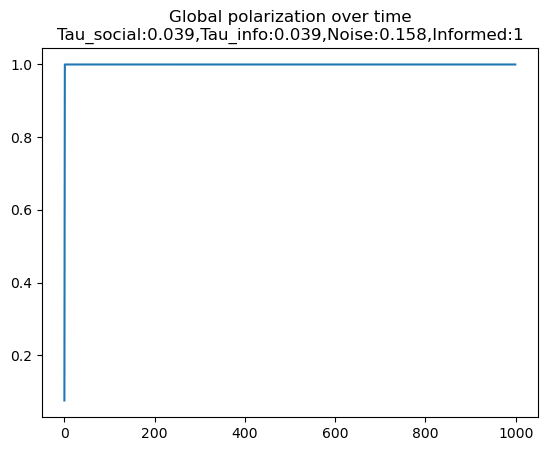

global polarization mean: 0.9997439467288531


In [31]:
calc_polarity_stat(output,params) 

In [ ]:
ani(output,params)

# experiment 2: global information

steps 910 N 2500


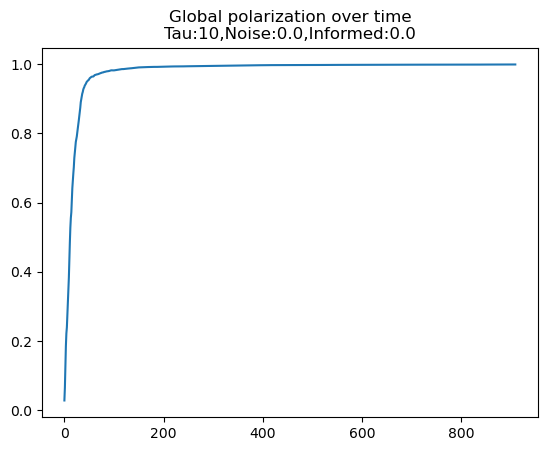

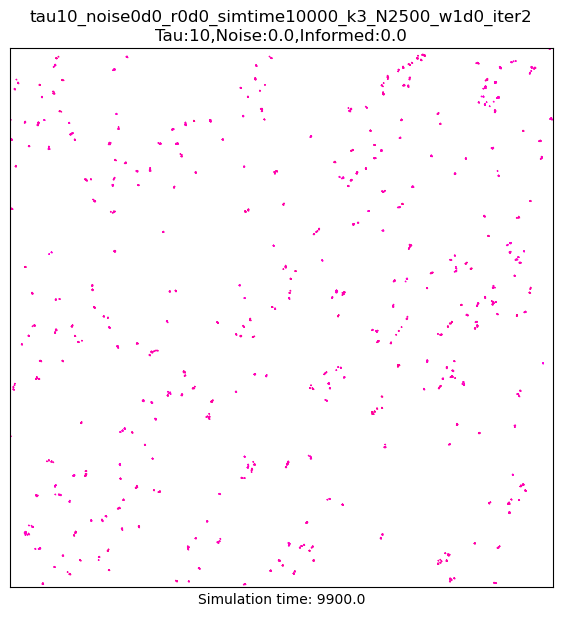

In [21]:
# no force
logname = 'tau10_noise0d0_r0d0_simtime10000_k3_N2500_w1d0_iter2'
analyze_pipe(logname)

steps 500 N 2500


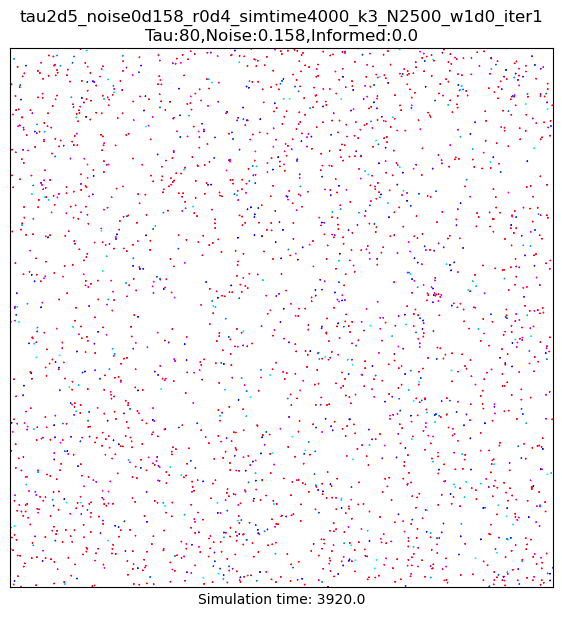

In [29]:
# effect of global force (with noise)
output,params = load_data_new('tau80_noise0d158_r0d0_simtime4000_k3_N2500_w1d0_iter1')
ani(output,params)
#output,params = load_data_new('tau80_noise0d158_r0d4_simtime4000_k3_N2500_w1d0_iter1')
#analyze_pipe('tau80_noise0d158_r0d4_simtime4000_k3_N2500_w1d0_iter1')

steps 500 N 2500


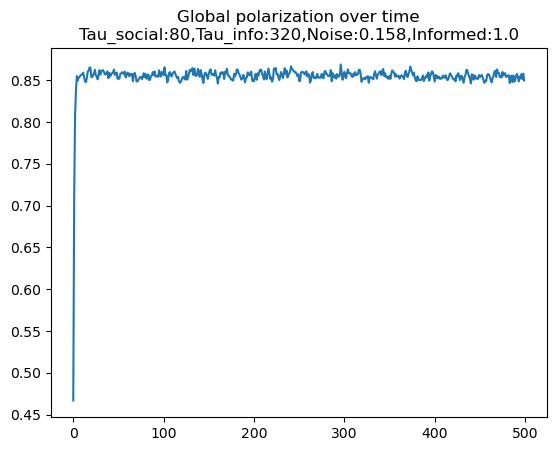

'simulation too short to reach equilibrium'

In [39]:
logname = 'tau80_noise0d158_r1d0_simtime4000_k3_N2500_w1d0_iter5'
output,params = load_data_new(logname)
calc_polarity_stat(output,params)

In [70]:
#tauinfo 2.5 winformed 1
lognames = ['tau80_noise0d158_r0_simtime10000_k3_N2500_w1d0_iter2',
            'tau80_noise0d158_r0d2_simtime10000_k3_N2500_w1d0_iter3',
            'tau80_noise0d158_r0d4_simtime10000_k3_N2500_w1d0_iter3',
            'tau80_noise0d158_r0d6_simtime10000_k3_N2500_w1d0_iter3',
            'tau80_noise0d158_r0d8_simtime10000_k3_N2500_w1d0_iter3',
            'tau80_noise0d158_r1d0_simtime10000_k3_N2500_w1d0_iter3']
for logname in lognames:
    output,params=load_data_new(logname)
    print(calc_polarity_stat(output,params))

steps 625 N 2500
0.06220892832198454
None
steps 625 N 2500
0.031046157417945825
None
steps 625 N 2500
0.030580659427964577
None
steps 625 N 2500
0.03380564841799041
None
steps 625 N 2500
0.03685927400751956
None
steps 625 N 2500
0.03527418095590527
None


In [82]:
lognames = ['tau80_noise0d158_r0_simtime10000_k3_N2500_w1d0_iter3',
            'tau80_noise0d158_r0d2_simtime10000_k3_N2500_w1d0_iter4',
            'tau80_noise0d158_r0d4_simtime10000_k3_N2500_w1d0_iter4',
            'tau80_noise0d158_r0d6_simtime10000_k3_N2500_w1d0_iter4',
            'tau80_noise0d158_r0d8_simtime10000_k3_N2500_w1d0_iter4',
            'tau80_noise0d158_r1d0_simtime10000_k3_N2500_w1d0_iter4']
for logname in lognames:
    output,params=load_data_new(logname)
    print(calc_polarity_stat(output,params))

steps 625 N 2500
0.048496701603994496
None
steps 625 N 2500
0.4849106106184969
None
steps 625 N 2500
0.6224948175136685
None
steps 625 N 2500
0.716632458604104
None
steps 625 N 2500
0.7945900234163173
None
steps 625 N 2500
0.8560423236220763
None


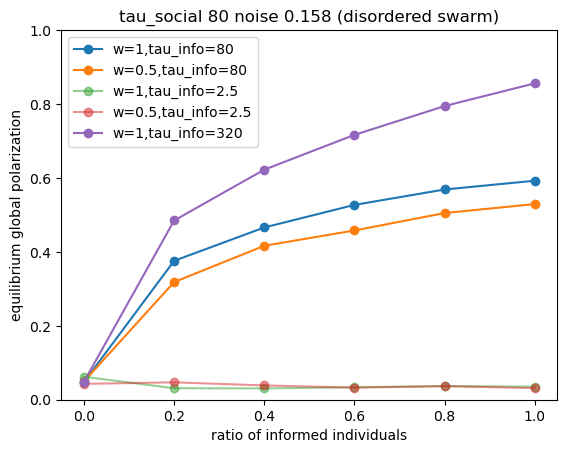

In [84]:
ratios = [0.,.2,.4,.6,.8,1.]
polarization = [0.047728032430158045,0.37580982434059756,0.4660856452175724,0.5271246280873412,0.5688725903074178,0.592532502841809]
polarizationw0d5 = [0.049546861142816874,0.31837548879472993,0.41651234426310174,0.4579416803236943,0.5050917220795046,0.5293816995669993]
polarw1t2d5 = [0.06220892832198454,0.031046157417945825,0.030580659427964577,0.03380564841799041,0.03685927400751956,0.03527418095590527]
polarw0d5t2d5 = [0.042915647370387826,0.047070781940816174,0.03865707866111567,0.03264238009361878,0.03667135994264299,0.03139994523397515]
polart320w1 = [0.048496701603994496,0.4849106106184969,0.6224948175136685,0.716632458604104,0.7945900234163173,0.8560423236220763]
plt.plot(ratios,polarization,'-o',label="w=1,tau_info=80")
plt.plot(ratios,polarizationw0d5,'-o',label="w=0.5,tau_info=80")
plt.plot(ratios,polarw1t2d5,'-o',alpha=0.5,label="w=1,tau_info=2.5")
plt.plot(ratios,polarw0d5t2d5,'-o',alpha=0.5,label="w=0.5,tau_info=2.5")
plt.plot(ratios,polart320w1,'-o',label="w=1,tau_info=320")

plt.xlabel("ratio of informed individuals")
plt.ylabel("equilibrium global polarization")
plt.title("tau_social 80 noise 0.158 (disordered swarm)")
plt.ylim(0,1)
plt.legend()
plt.show()